100%|████████████████████████████████████████| 170M/170M [00:23<00:00, 7.37MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/20], Loss: 0.0229
Epoch [2/20], Loss: 0.0131
Epoch [3/20], Loss: 0.0113
Epoch [4/20], Loss: 0.0104
Epoch [5/20], Loss: 0.0097
Epoch [6/20], Loss: 0.0092
Epoch [7/20], Loss: 0.0088
Epoch [8/20], Loss: 0.0085
Epoch [9/20], Loss: 0.0082
Epoch [10/20], Loss: 0.0081
Epoch [11/20], Loss: 0.0079
Epoch [12/20], Loss: 0.0078
Epoch [13/20], Loss: 0.0078
Epoch [14/20], Loss: 0.0077
Epoch [15/20], Loss: 0.0077
Epoch [16/20], Loss: 0.0077
Epoch [17/20], Loss: 0.0076
Epoch [18/20], Loss: 0.0075
Epoch [19/20], Loss: 0.0073
Epoch [20/20], Loss: 0.0073
Average SSIM: 0.7096
Average PSNR: 21.9069
Average MAE: 0.0616
Average MSE: 0.0073


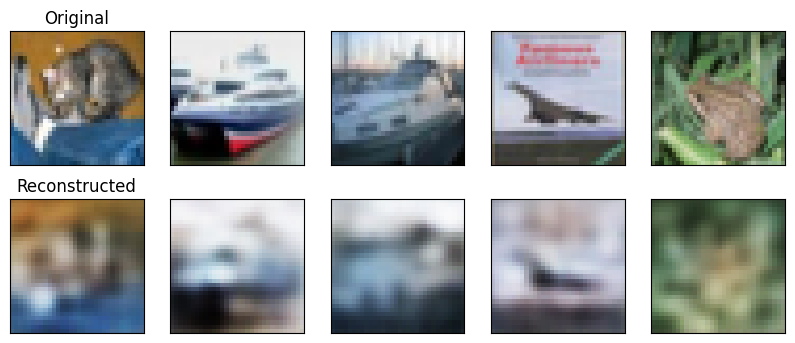

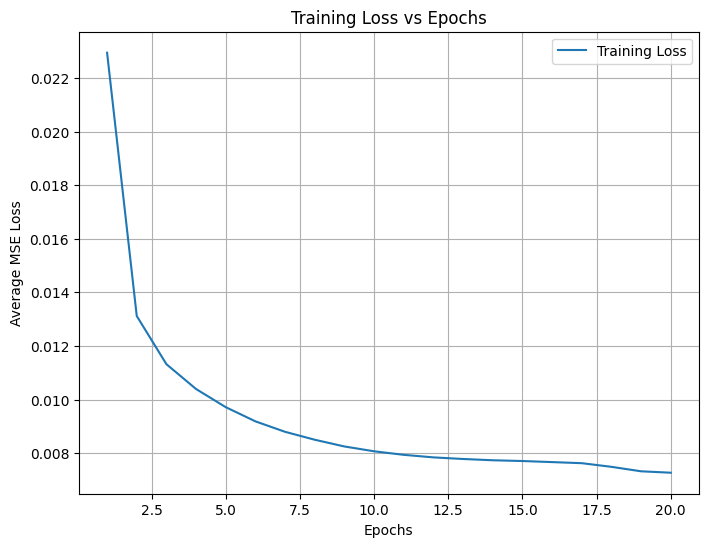

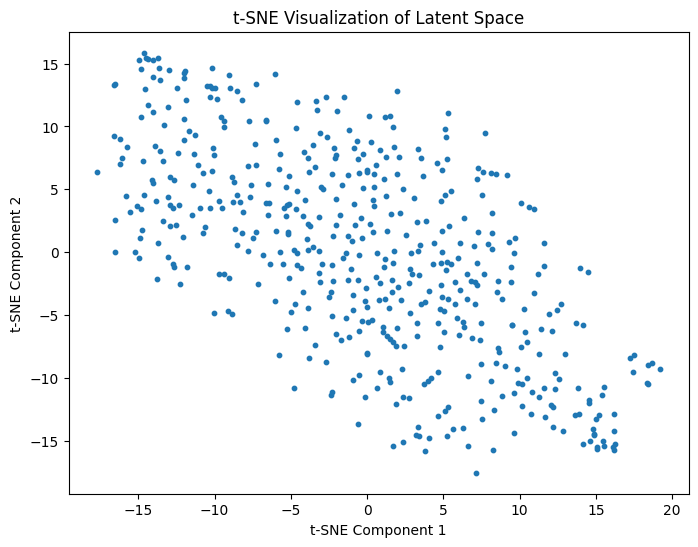

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 20
batch_size = 64
learning_rate = 0.001
latent_dim = 128  # Size of the latent space

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors (range [0, 1])
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Standard Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: Conv layers to compress the image
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, latent_dim),  # Fully connected layer to latent space
            nn.ReLU()
        )
        # Decoder: Transpose Conv layers to reconstruct the image
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),  # Reshape to feature map
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.Sigmoid()  # Output in range [0, 1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

# Initialize model, loss, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        images, _ = data  # Ignore labels
        images = images.to(device)

        # Forward pass
        outputs, _ = model(images)
        loss = criterion(outputs, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation on test set
model.eval()
test_images = []
reconstructed_images = []
latent_vectors = []
ssim_scores, psnr_scores, mae_scores, mse_scores = [], [], [], []

with torch.no_grad():
    for data in test_loader:
        images, _ = data
        images = images.to(device)
        outputs, latent = model(images)

        # Store for visualization and latent space analysis
        test_images.append(images.cpu().numpy())
        reconstructed_images.append(outputs.cpu().numpy())
        latent_vectors.append(latent.cpu().numpy())

        # Compute evaluation metrics
        for i in range(images.size(0)):
            orig = images[i].cpu().numpy().transpose(1, 2, 0)  # HWC format
            recon = outputs[i].cpu().numpy().transpose(1, 2, 0)
            ssim_score = ssim(orig, recon, channel_axis=2, data_range=1.0)
            psnr_score = psnr(orig, recon, data_range=1.0)
            mae_score = mean_absolute_error(orig.flatten(), recon.flatten())
            mse_score = mean_squared_error(orig.flatten(), recon.flatten())

            ssim_scores.append(ssim_score)
            psnr_scores.append(psnr_score)
            mae_scores.append(mae_score)
            mse_scores.append(mse_score)

# Concatenate results
test_images = np.concatenate(test_images)
reconstructed_images = np.concatenate(reconstructed_images)
latent_vectors = np.concatenate(latent_vectors)

# Print average metrics
print(f"Average SSIM: {np.mean(ssim_scores):.4f}")
print(f"Average PSNR: {np.mean(psnr_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f}")
print(f"Average MSE: {np.mean(mse_scores):.4f}")

# Visualize original vs reconstructed images
def plot_images(original, reconstructed, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            plt.title("Original")

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            plt.title("Reconstructed")
    plt.show()

plot_images(test_images, reconstructed_images)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Average MSE Loss")
plt.title("Training Loss vs Epochs")
plt.legend()
plt.grid()
plt.show()

# Visualize latent space using t-SNE
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors[:500])  # Use subset for speed

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=10)
plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out


In [6]:
def add_gaussian_noise(images, std):
    noise = torch.randn_like(images) * std
    noisy_images = images + noise
    return torch.clip(noisy_images, 0., 1.)


In [8]:

transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|█| 9.91M/9.91M [00:02<00:00, 3.55M


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█| 28.9k/28.9k [00:00<00:00, 53.1k


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█| 1.65M/1.65M [00:06<00:00, 238kB


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█| 4.54k/4.54k [00:00<00:00, 21.6M

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
def train(model, loader, noise_std=0.0, num_epochs=20, model_name="DAE"):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.to(device)
    
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        for images, _ in loader:
            images = images.to(device)
            noisy_images = add_gaussian_noise(images, noise_std).to(device) if noise_std > 0 else images

            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        print(f"{model_name} Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    return losses


In [12]:
def visualize_reconstructions(model, loader, noise_std=0.0, num_images=5):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(loader))
        images = images.to(device)
        noisy_images = add_gaussian_noise(images, noise_std).to(device) if noise_std > 0 else images
        recon = model(noisy_images)

        fig, axes = plt.subplots(num_images, 3, figsize=(8, 10))
        for i in range(num_images):
            axes[i, 0].imshow(images[i].cpu().squeeze(), cmap='gray')
            axes[i, 0].set_title("Original")
            axes[i, 1].imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
            axes[i, 1].set_title(f"Noisy σ={noise_std}")
            axes[i, 2].imshow(recon[i].cpu().squeeze(), cmap='gray')
            axes[i, 2].set_title("Reconstructed")
        plt.tight_layout()
        plt.show()


In [14]:
def extract_features_and_labels(model, loader):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            latent = model.encoder(images)
            features.append(latent.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

def classify_latents(train_feats, train_lbls, test_feats, test_lbls):
    clf = LogisticRegression(max_iter=200)
    clf.fit(train_feats, train_lbls)
    preds = clf.predict(test_feats)
    acc = accuracy_score(test_lbls, preds)
    print(f"Latent Feature Classification Accuracy: {acc * 100:.2f}%")


In [16]:
# Train AE
ae = Autoencoder()
ae_losses = train(ae, train_loader, noise_std=0.0, model_name="AE")

# Train DAE with different noise levels
dae_models = {}
dae_losses = {}

for std in [0.1, 0.3, 0.5]:
    dae = Autoencoder()
    loss = train(dae, train_loader, noise_std=std, model_name=f"DAE σ={std}")
    dae_models[std] = dae
    dae_losses[std] = loss


AE Epoch [1/20], Loss: 0.0601
AE Epoch [2/20], Loss: 0.0300
AE Epoch [3/20], Loss: 0.0237
AE Epoch [4/20], Loss: 0.0210
AE Epoch [5/20], Loss: 0.0191
AE Epoch [6/20], Loss: 0.0177
AE Epoch [7/20], Loss: 0.0164
AE Epoch [8/20], Loss: 0.0154
AE Epoch [9/20], Loss: 0.0145
AE Epoch [10/20], Loss: 0.0137
AE Epoch [11/20], Loss: 0.0130
AE Epoch [12/20], Loss: 0.0124
AE Epoch [13/20], Loss: 0.0120
AE Epoch [14/20], Loss: 0.0116
AE Epoch [15/20], Loss: 0.0112
AE Epoch [16/20], Loss: 0.0109
AE Epoch [17/20], Loss: 0.0106
AE Epoch [18/20], Loss: 0.0103
AE Epoch [19/20], Loss: 0.0101
AE Epoch [20/20], Loss: 0.0098
DAE σ=0.1 Epoch [1/20], Loss: 0.0643
DAE σ=0.1 Epoch [2/20], Loss: 0.0344
DAE σ=0.1 Epoch [3/20], Loss: 0.0274
DAE σ=0.1 Epoch [4/20], Loss: 0.0231
DAE σ=0.1 Epoch [5/20], Loss: 0.0208
DAE σ=0.1 Epoch [6/20], Loss: 0.0190
DAE σ=0.1 Epoch [7/20], Loss: 0.0175
DAE σ=0.1 Epoch [8/20], Loss: 0.0163
DAE σ=0.1 Epoch [9/20], Loss: 0.0155
DAE σ=0.1 Epoch [10/20], Loss: 0.0148
DAE σ=0.1 Epoch [1

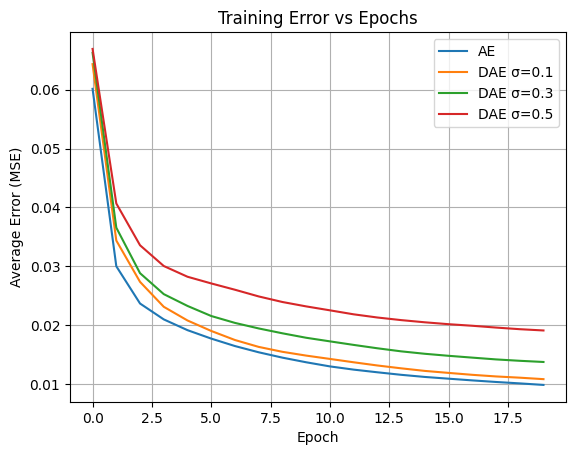

In [17]:
plt.plot(ae_losses, label="AE")
for std, loss in dae_losses.items():
    plt.plot(loss, label=f"DAE σ={std}")
plt.xlabel("Epoch")
plt.ylabel("Average Error (MSE)")
plt.title("Training Error vs Epochs")
plt.legend()
plt.grid()
plt.show()


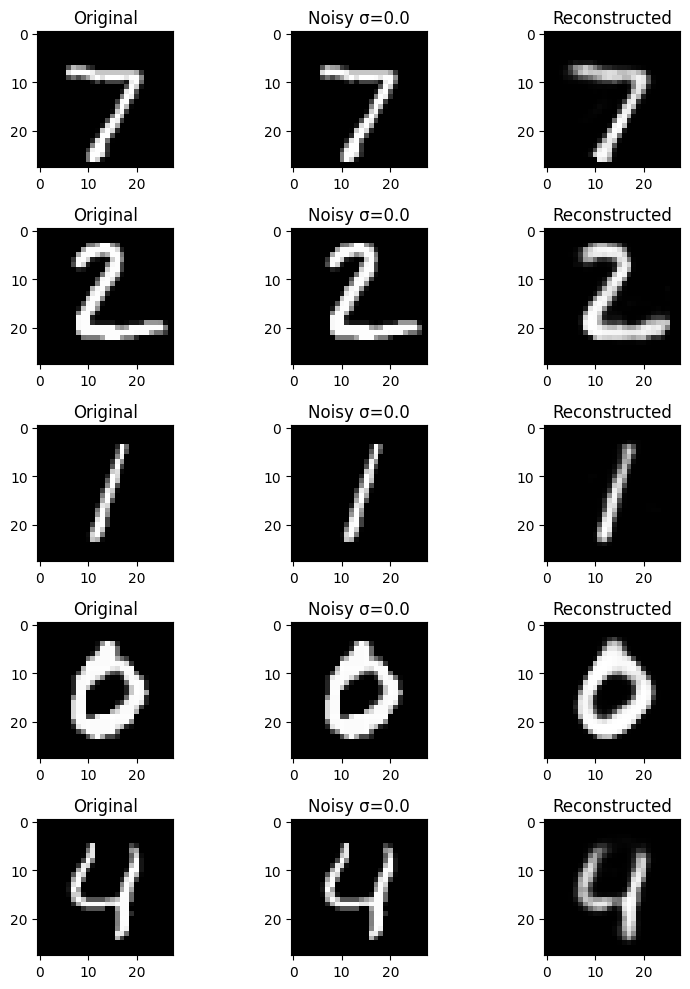

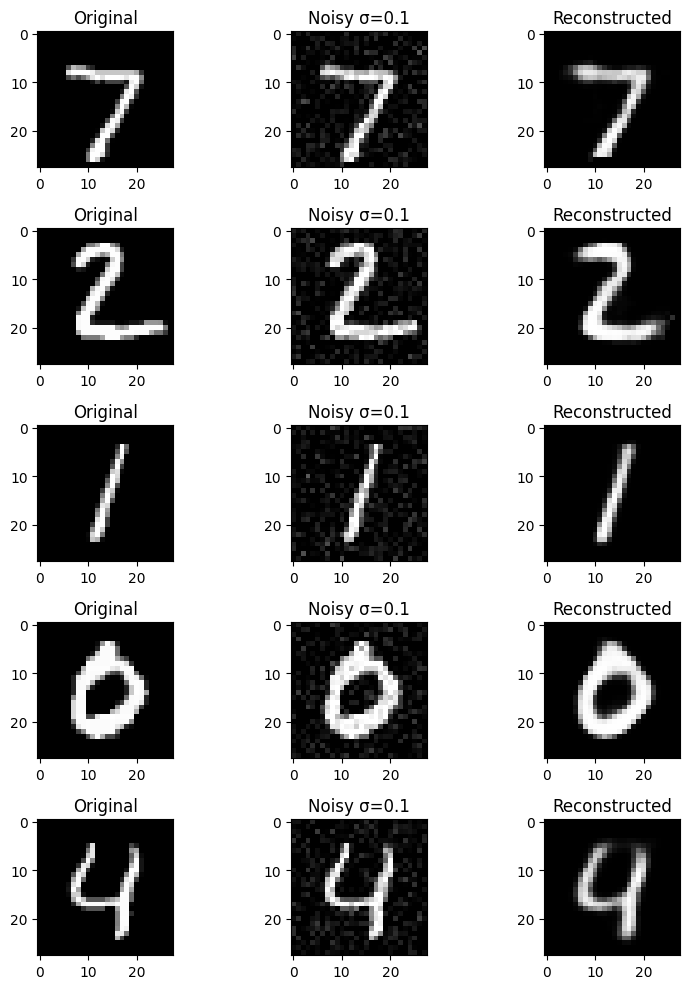

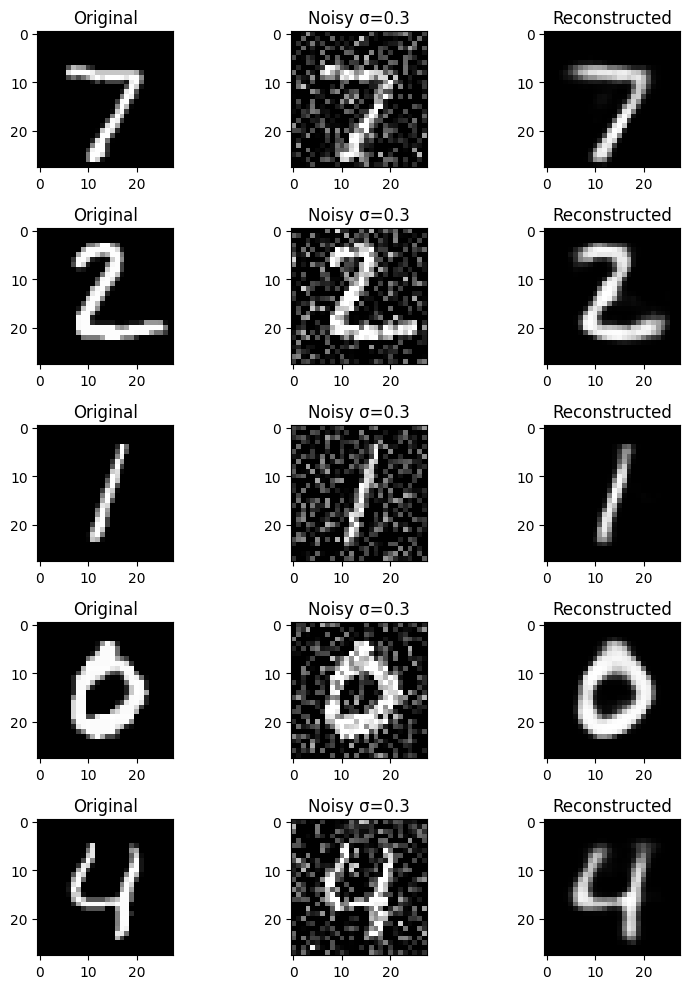

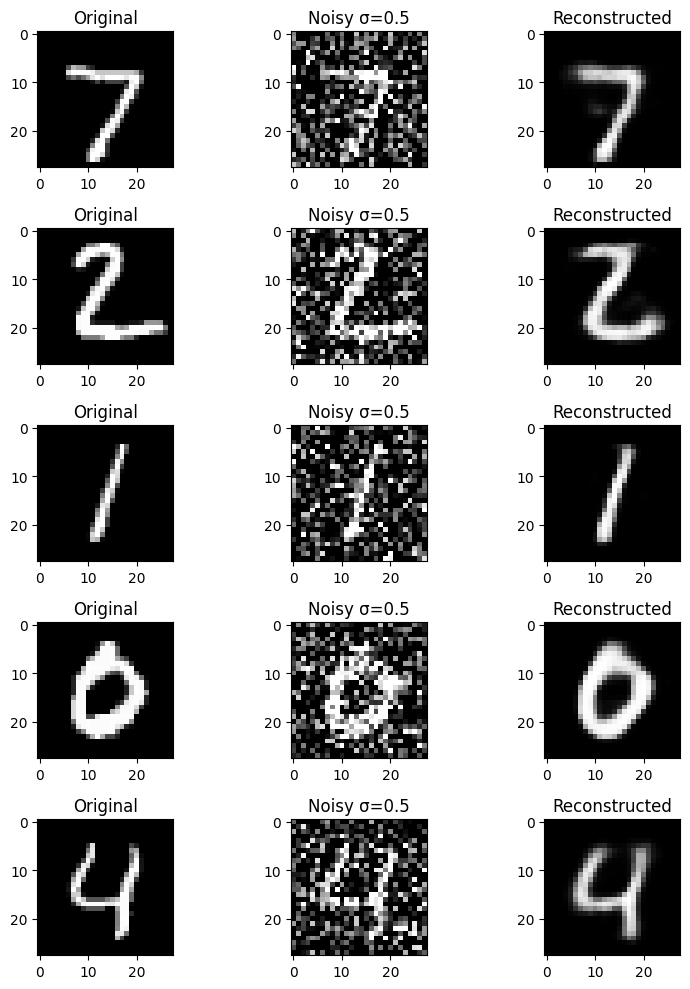

/home/ub/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Latent Feature Classification Accuracy: 90.76%
DAE σ=0.1:


/home/ub/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Latent Feature Classification Accuracy: 91.01%
DAE σ=0.3:


/home/ub/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Latent Feature Classification Accuracy: 91.27%
DAE σ=0.5:
Latent Feature Classification Accuracy: 90.85%


/home/ub/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
# Visualize AE and DAE reconstructions
visualize_reconstructions(ae, test_loader, noise_std=0.0)
for std in [0.1, 0.3, 0.5]:
    visualize_reconstructions(dae_models[std], test_loader, noise_std=std)

# Classification from latent features
ae_feats_train, ae_lbls_train = extract_features_and_labels(ae, train_loader)
ae_feats_test, ae_lbls_test = extract_features_and_labels(ae, test_loader)
classify_latents(ae_feats_train, ae_lbls_train, ae_feats_test, ae_lbls_test)

for std in [0.1, 0.3, 0.5]:
    dae = dae_models[std]
    dae_feats_train, dae_lbls_train = extract_features_and_labels(dae, train_loader)
    dae_feats_test, dae_lbls_test = extract_features_and_labels(dae, test_loader)
    print(f"DAE σ={std}:")
    classify_latents(dae_feats_train, dae_lbls_train, dae_feats_test, dae_lbls_test)


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 64x8x8
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64*8*8, latent_dim)
        self.fc_logvar = nn.Linear(64*8*8, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 64*8*8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 8, 8)),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 32x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), # 3x32x32
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [25]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [28]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div, recon_loss, kl_div


In [30]:
import matplotlib.pyplot as plt

def train_vae(model, dataloader, num_epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.to(device)
    total_loss, kl_loss, recon_loss = [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, epoch_kl, epoch_recon = 0, 0, 0
        for batch, _ in dataloader:
            batch = batch.to(device)
            recon, mu, logvar = model(batch)
            loss, r_loss, k_loss = vae_loss(recon, batch, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_kl += k_loss.item()
            epoch_recon += r_loss.item()
        
        total_loss.append(epoch_loss)
        recon_loss.append(epoch_recon)
        kl_loss.append(epoch_kl)
        print(f"Epoch {epoch+1}, Total: {epoch_loss:.2f}, Recon: {epoch_recon:.2f}, KL: {epoch_kl:.2f}")

    return total_loss, recon_loss, kl_loss


In [32]:
def plot_losses(total, recon, kl):
    plt.plot(total, label='Total Loss')
    plt.plot(recon, label='Reconstruction Loss')
    plt.plot(kl, label='KL Divergence')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("VAE Training Losses")
    plt.grid()
    plt.show()


In [34]:
def interpolate_latents(model, img1, img2, steps=10):
    model.eval()
    mu1, _ = model.encode(img1.unsqueeze(0).to(device))
    mu2, _ = model.encode(img2.unsqueeze(0).to(device))

    interpolated_imgs = []
    for alpha in torch.linspace(0, 1, steps):
        z = (1 - alpha) * mu1 + alpha * mu2
        out = model.decode(z).squeeze(0).cpu().permute(1, 2, 0).detach()
        interpolated_imgs.append(out.numpy())
    
    fig, axes = plt.subplots(1, steps, figsize=(15, 2))
    for i, img in enumerate(interpolated_imgs):
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.suptitle("Latent Space Interpolation")
    plt.show()


In [36]:
def latent_arithmetic(model, img1, img2, img3):
    model.eval()
    mu1, _ = model.encode(img1.unsqueeze(0).to(device))  # "dog"
    mu2, _ = model.encode(img2.unsqueeze(0).to(device))  # "cat"
    mu3, _ = model.encode(img3.unsqueeze(0).to(device))  # "bird"

    result_latent = mu1 - mu2 + mu3
    out = model.decode(result_latent).squeeze(0).cpu().permute(1, 2, 0).detach().numpy()

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i, img in enumerate([img1, img2, img3]):
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].axis('off')
    axes[0].set_title("Dog")
    axes[1].set_title("Cat")
    axes[2].set_title("Bird")

    axes[3].imshow(out)
    axes[3].axis('off')
    axes[3].set_title("Dog - Cat + Bird")
    plt.show()


In [38]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

def evaluate_metrics(model, dataloader):
    model.eval()
    all_ssim, all_psnr, all_mae, all_mse = [], [], [], []

    with torch.no_grad():
        for batch, _ in dataloader:
            batch = batch.to(device)
            recon, _, _ = model(batch)
            for i in range(batch.size(0)):
                original = batch[i].permute(1, 2, 0).cpu().numpy()
                reconstructed = recon[i].permute(1, 2, 0).cpu().numpy()

                all_ssim.append(ssim(original, reconstructed, channel_axis=-1, data_range=1.0))
                all_psnr.append(psnr(original, reconstructed, data_range=1.0))
                all_mae.append(np.mean(np.abs(original - reconstructed)))
                all_mse.append(np.mean((original - reconstructed) ** 2))
    
    print(f"SSIM: {np.mean(all_ssim):.4f}, PSNR: {np.mean(all_psnr):.2f}, MAE: {np.mean(all_mae):.4f}, MSE: {np.mean(all_mse):.6f}")


Epoch 1, Total: 6265993.77, Recon: 5617768.81, KL: 648224.94
Epoch 2, Total: 4611386.56, Recon: 3645510.75, KL: 965875.81
Epoch 3, Total: 4167350.99, Recon: 3186117.58, KL: 981233.42
Epoch 4, Total: 4055384.24, Recon: 3046123.89, KL: 1009260.34
Epoch 5, Total: 3999174.70, Recon: 2965079.58, KL: 1034095.13
Epoch 6, Total: 3948736.06, Recon: 2894509.82, KL: 1054226.25
Epoch 7, Total: 3908590.63, Recon: 2841987.18, KL: 1066603.46
Epoch 8, Total: 3890311.60, Recon: 2816885.48, KL: 1073426.12
Epoch 9, Total: 3873746.54, Recon: 2794028.92, KL: 1079717.62
Epoch 10, Total: 3859793.46, Recon: 2773863.49, KL: 1085929.98
Epoch 11, Total: 3847557.08, Recon: 2750654.48, KL: 1096902.60
Epoch 12, Total: 3835541.25, Recon: 2730910.81, KL: 1104630.45
Epoch 13, Total: 3824319.59, Recon: 2714047.51, KL: 1110272.08
Epoch 14, Total: 3813787.28, Recon: 2700952.58, KL: 1112834.70
Epoch 15, Total: 3807552.33, Recon: 2689643.59, KL: 1117908.73
Epoch 16, Total: 3800028.96, Recon: 2678332.06, KL: 1121696.90
Epoc

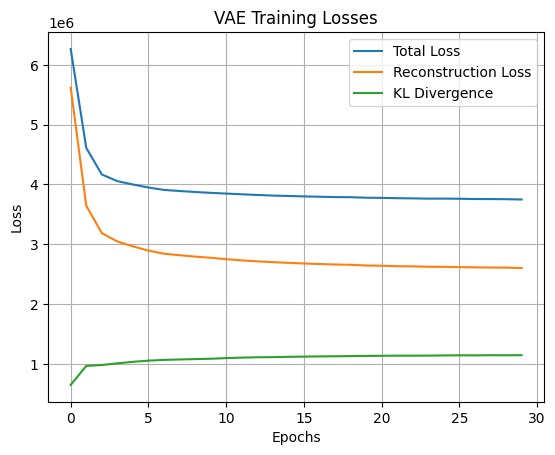

SSIM: 0.4224, PSNR: 18.03, MAE: 0.0981, MSE: 0.017091


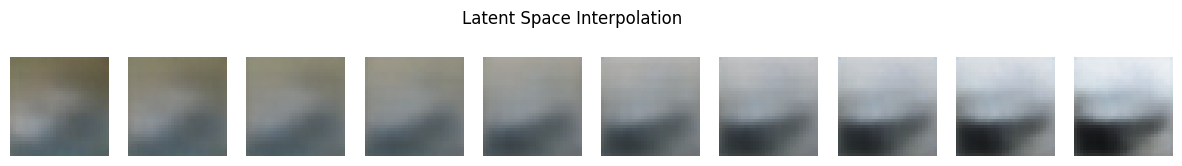

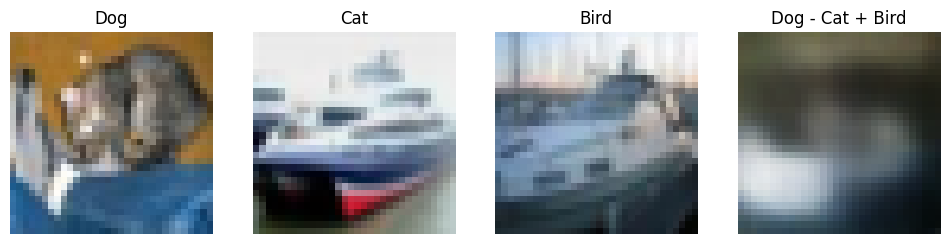

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE(latent_dim=128).to(device)
total_loss, recon_loss, kl_loss = train_vae(vae, train_loader, num_epochs=30)

plot_losses(total_loss, recon_loss, kl_loss)

# Evaluate image quality
evaluate_metrics(vae, test_loader)

# Interpolate between 2 test images
img_batch, _ = next(iter(test_loader))
interpolate_latents(vae, img_batch[0], img_batch[1])

# Arithmetic: dog - cat + bird
latent_arithmetic(vae, img_batch[0], img_batch[1], img_batch[2])


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class MCAE(nn.Module):
    def __init__(self, masking_ratio=0.5):
        super(MCAE, self).__init__()
        self.masking_ratio = masking_ratio

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # [64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # [128, 8, 8]
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # [64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),    # [3, 32, 32]
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)  # [B, 128, 8, 8]
        masked, mask = self.apply_mask(encoded.clone())
        decoded = self.decoder(masked)
        return decoded, encoded.detach(), mask

    def apply_mask(self, feat_map):
        B, C, H, W = feat_map.size()
        mask = torch.rand(B, 1, H, W, device=feat_map.device) > self.masking_ratio
        feat_map = feat_map * mask
        return feat_map, mask


In [42]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [44]:
def train_mcae(model, loader, num_epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    model.to(device)

    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for imgs, _ in loader:
            imgs = imgs.to(device)
            recon, _, _ = model(imgs)
            loss = criterion(recon, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return losses


In [69]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_reconstruction(model, dataloader):
    model.eval()
    imgs, _ = next(iter(dataloader))
    imgs = imgs[:6].to(device)

    with torch.no_grad():
        recon, _, mask = model(imgs)  # mask: [B, 1, 8, 8] or bool

    fig, axes = plt.subplots(6, 3, figsize=(9, 10))
    for i in range(6):
        axes[i][0].imshow(imgs[i].cpu().permute(1, 2, 0))
        axes[i][0].set_title("Original")

        # Fix: Convert boolean mask to float before upsampling
        up_mask = F.interpolate(mask[i].unsqueeze(0).float(), size=(32, 32), mode='nearest')[0]
        masked_img = (up_mask.repeat(3, 1, 1) * imgs[i]).cpu()

        axes[i][1].imshow(masked_img.permute(1, 2, 0))
        axes[i][1].set_title("Masked")

        axes[i][2].imshow(recon[i].cpu().permute(1, 2, 0))
        axes[i][2].set_title("Reconstructed")

        for j in range(3):
            axes[i][j].axis('off')

    plt.tight_layout()
    plt.show()



In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def extract_embeddings(model, loader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            _, encoded, _ = model(imgs)
            encoded = encoded.mean([2, 3])  # Global average pool
            features.append(encoded.cpu().numpy())
            labels.append(lbls.numpy())
    return np.vstack(features), np.hstack(labels)

def train_linear_classifier(model, train_loader, test_loader):
    X_train, y_train = extract_embeddings(model, train_loader)
    X_test, y_test = extract_embeddings(model, test_loader)

    clf = LogisticRegression(max_iter=200)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    print(f"Linear Classifier Accuracy (Frozen Encoder): {acc * 100:.2f}%")
    return acc


In [73]:
import seaborn as sns

def show_heatmap(img, mask):
    heatmap = mask.squeeze().cpu().numpy()
    plt.figure(figsize=(4, 4))
    sns.heatmap(heatmap, cmap='viridis', cbar=False)
    plt.title("Reconstruction Focus (Mask Map)")
    plt.axis('off')
    plt.show()


In [75]:
from sklearn.decomposition import PCA

def plot_decision_region(model, loader):
    X, y = extract_embeddings(model, loader)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    clf = LogisticRegression()
    clf.fit(X_pca, y)

    h = .02
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=15, cmap='tab10')
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("Decision Region using MCAE Embeddings")
    plt.show()



--- Training MCAE with Masking Ratio 25% ---
Epoch 1, Loss: 0.0101
Epoch 2, Loss: 0.0040
Epoch 3, Loss: 0.0031
Epoch 4, Loss: 0.0026
Epoch 5, Loss: 0.0024
Epoch 6, Loss: 0.0022
Epoch 7, Loss: 0.0021
Epoch 8, Loss: 0.0020
Epoch 9, Loss: 0.0019
Epoch 10, Loss: 0.0018
Epoch 11, Loss: 0.0017
Epoch 12, Loss: 0.0017
Epoch 13, Loss: 0.0017
Epoch 14, Loss: 0.0016
Epoch 15, Loss: 0.0016
Epoch 16, Loss: 0.0015
Epoch 17, Loss: 0.0015
Epoch 18, Loss: 0.0014
Epoch 19, Loss: 0.0014
Epoch 20, Loss: 0.0014


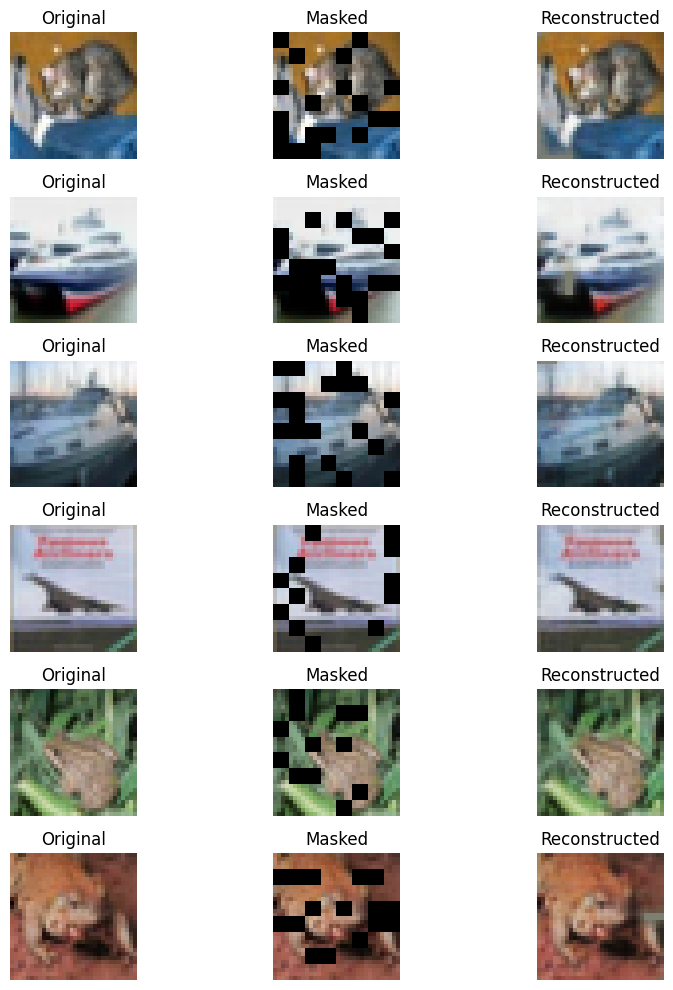

/home/ub/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Classifier Accuracy (Frozen Encoder): 34.36%


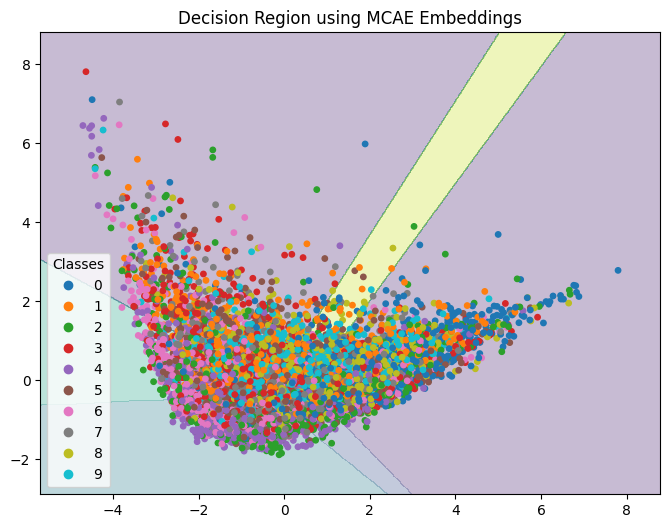


--- Training MCAE with Masking Ratio 50% ---
Epoch 1, Loss: 0.0154
Epoch 2, Loss: 0.0087
Epoch 3, Loss: 0.0075
Epoch 4, Loss: 0.0070
Epoch 5, Loss: 0.0066
Epoch 6, Loss: 0.0063
Epoch 7, Loss: 0.0062
Epoch 8, Loss: 0.0060
Epoch 9, Loss: 0.0059
Epoch 10, Loss: 0.0057
Epoch 11, Loss: 0.0056
Epoch 12, Loss: 0.0056
Epoch 13, Loss: 0.0055
Epoch 14, Loss: 0.0054
Epoch 15, Loss: 0.0054
Epoch 16, Loss: 0.0053
Epoch 17, Loss: 0.0053
Epoch 18, Loss: 0.0053
Epoch 19, Loss: 0.0052
Epoch 20, Loss: 0.0052


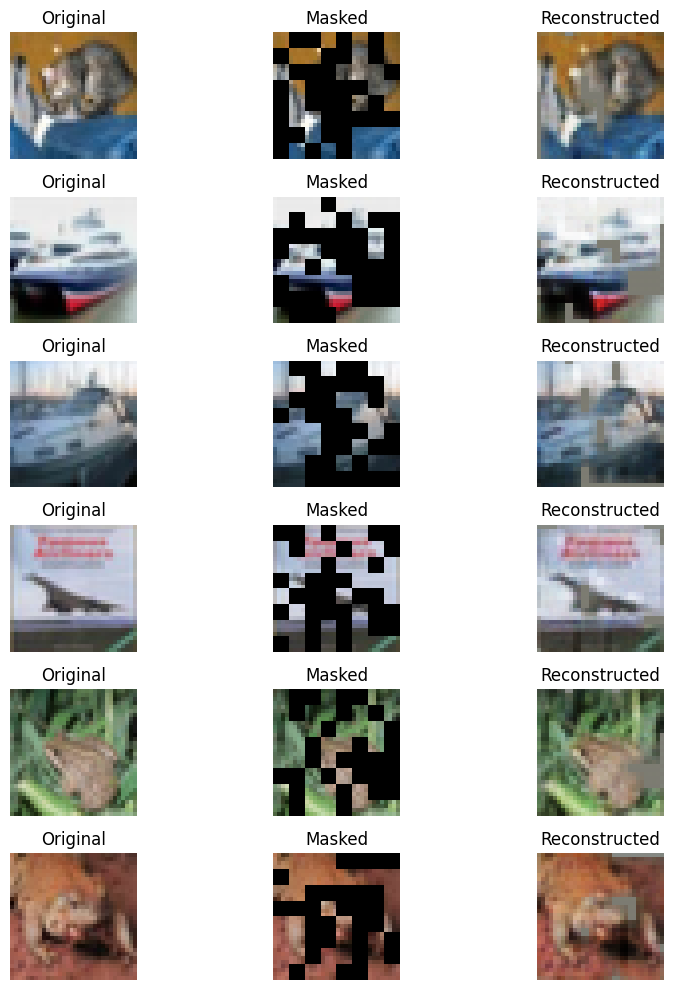

/home/ub/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Classifier Accuracy (Frozen Encoder): 34.81%


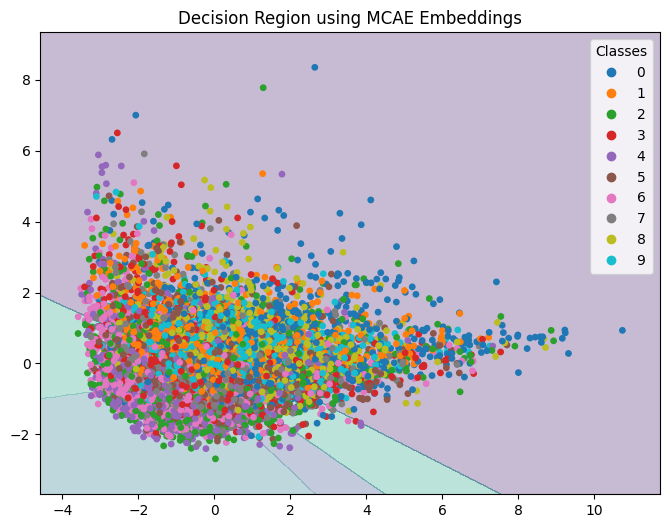


--- Training MCAE with Masking Ratio 75% ---
Epoch 1, Loss: 0.0266
Epoch 2, Loss: 0.0211
Epoch 3, Loss: 0.0201
Epoch 4, Loss: 0.0195
Epoch 5, Loss: 0.0192
Epoch 6, Loss: 0.0189
Epoch 7, Loss: 0.0187
Epoch 8, Loss: 0.0186
Epoch 9, Loss: 0.0184
Epoch 10, Loss: 0.0183
Epoch 11, Loss: 0.0182
Epoch 12, Loss: 0.0182
Epoch 13, Loss: 0.0180
Epoch 14, Loss: 0.0181
Epoch 15, Loss: 0.0179
Epoch 16, Loss: 0.0179
Epoch 17, Loss: 0.0179
Epoch 18, Loss: 0.0178
Epoch 19, Loss: 0.0178
Epoch 20, Loss: 0.0178


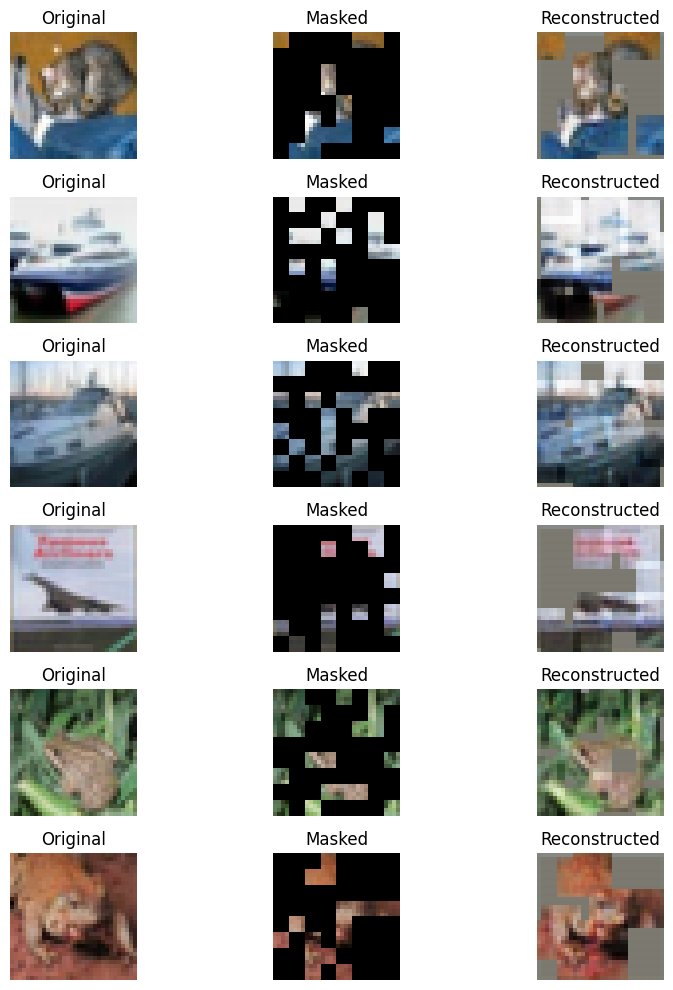

/home/ub/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Classifier Accuracy (Frozen Encoder): 33.35%


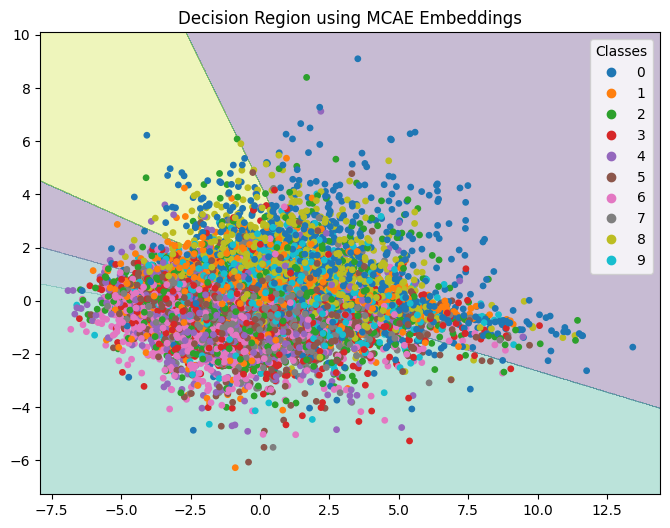

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for ratio in [0.25, 0.5, 0.75]:
    print(f"\n--- Training MCAE with Masking Ratio {int(ratio*100)}% ---")
    mcae = MCAE(masking_ratio=ratio).to(device)
    train_mcae(mcae, train_loader, num_epochs=20)

    visualize_reconstruction(mcae, test_loader)
    acc = train_linear_classifier(mcae, train_loader, test_loader)
    plot_decision_region(mcae, test_loader)
